In [39]:
# from scratch implementation with variables
import torch
import torch.nn.functional as F

In [40]:
words = open("../data/names.txt", "r").read().splitlines()

In [41]:
len(words)

32033

In [42]:
num_classes = 27

# hyperparameters
# number of input tokens to predict next token
block_size = 3

# splitting intro training, validation and test sets
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# embedding dimensions
embed_dims = 10
batch_size = 32

# num neurons
num_neurons = 200

training_iterations = 100000
learn_rate = 10 ** -1


In [43]:
# stoi and itos mapping
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


Main idea: convert into examples
Examples are triplets of words

Starting from `[0] * block_size` and then adding an ending character at the back

In [44]:
def build_dataset(words: list[str]):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        chs = word + "."
        for ch in chs:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [45]:
import random

random.seed(1)
random.shuffle(words)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

Main idea: set up the model weights

We have the embedding layer, the hidden layer and the output layer

In [46]:
C = torch.randn((num_classes, embed_dims))
W1 = torch.randn((block_size * embed_dims, num_neurons))
b1 = torch.randn((num_neurons))

W2 = torch.randn((num_neurons, num_classes))
b2 = torch.randn((num_classes))

Remember to set the gradient to true

In [47]:
params = [C, W1, b1, W2, b2]

In [48]:
sum(p.nelement() for p in params)

11897

In [49]:
for p in params:
    p.requires_grad = True

We can start our training of the model using backpropagation

Also include an array for us to store the log loss so that we can keep track of it

In [50]:
stepi = []
lossi = []

In [51]:
for i in range(training_iterations):
    # sample a batch of 32
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    embeds = (C[Xtr[ix]]).view(-1, block_size * embed_dims)
    h = torch.tanh(embeds @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in params:
        p.grad = None

    loss.backward()
    for p in params:
        p.data += -learn_rate * p.grad
    
    lossi.append(loss.log10().item())
    stepi.append(i)

print(loss.item())

2.4356462955474854


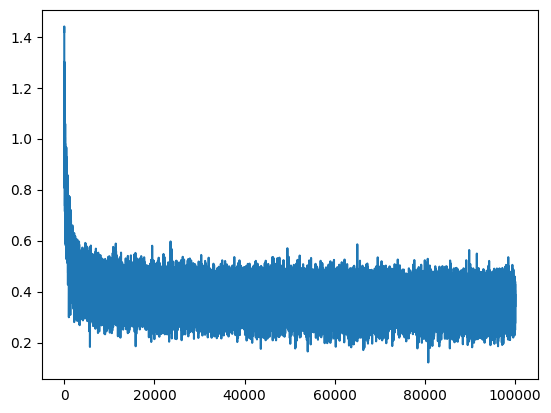

In [52]:
import matplotlib.pyplot as plt
plt.plot(stepi, lossi)